In [1]:
import env as env
from agent import agent
import utils
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Environment

In [2]:
environment = env.env()

In [3]:
environment.probability_matrix_df

0          1          2          3          4          5          6      
  left right left right left right left right left right left right left right
0  1.0   0.5  0.5   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0
1  0.0   0.5  0.5   0.5  0.5   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0
2  0.0   0.0  0.0   0.5  0.5   0.5  0.5   0.0  0.0   0.0  0.0   0.0  0.0   0.0
3  0.0   0.0  0.0   0.0  0.0   0.5  0.5   0.5  0.5   0.0  0.0   0.0  0.0   0.0
4  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.5  0.5   0.5  0.5   0.0  0.0   0.0
5  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.5  0.5   0.5  0.5   0.0
6  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.5  0.5   1.0

Select the probability matrix only for an action (example: left)

In [4]:
left_columns = [col for col in environment.probability_matrix_df.columns if 'left' in col]
environment.probability_matrix_df[left_columns]

,0,1,2,3,4,5,6
,left,left,left,left,left,left,left
0,1.0,0.5,0.0,0.0,0.0,0.0,0.0
1,0.0,0.5,0.5,0.0,0.0,0.0,0.0
2,0.0,0.0,0.5,0.5,0.0,0.0,0.0
3,0.0,0.0,0.0,0.5,0.5,0.0,0.0
4,0.0,0.0,0.0,0.0,0.5,0.5,0.0
5,0.0,0.0,0.0,0.0,0.0,0.5,0.5
6,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [5]:
environment.rewards_df 

,left,right
0,10.0,10.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,10.0,10.0


## Policy

We define a random starting policy.

In [6]:
policy = {}
for state in environment.states:
    for action in state.actions:
        if action.name == 'left':
            policy[(state.number, action.name)] = 1
        else:
            policy[(state.number, action.name)] = 0

In [7]:
'''
policy = {}
for state in environment.states:
    for action in state.actions:
        policy[(state.number, action.name)] = 1/len(state.actions)
'''

'\npolicy = {}\nfor state in environment.states:\n    for action in state.actions:\n        policy[(state.number, action.name)] = 1/len(state.actions)\n'

In [8]:
agent = agent(policy,environment)

In [9]:
agent.policy

{(0, 'left'): 1,
 (0, 'right'): 0,
 (1, 'left'): 1,
 (1, 'right'): 0,
 (2, 'left'): 1,
 (2, 'right'): 0,
 (3, 'left'): 1,
 (3, 'right'): 0,
 (4, 'left'): 1,
 (4, 'right'): 0,
 (5, 'left'): 1,
 (5, 'right'): 0,
 (6, 'left'): 1,
 (6, 'right'): 0}

In [10]:
agent.easy_policy

{0: 'left', 1: 'left', 2: 'left', 3: 'left', 4: 'left', 5: 'left', 6: 'left'}

This visualization of the policy takes into account the probability matrix for the edges' label.

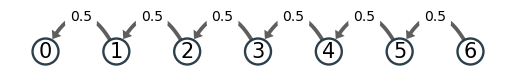

In [11]:
utils.visualize_policy(environment, agent)

Let's try sampling episodes according to the initial policy.

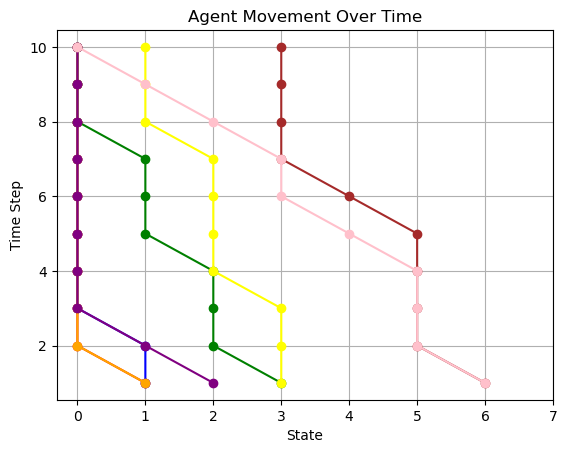

In [12]:
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'brown', 'pink']

for i in range(len(colors)):
    episode = agent.sample_episode(10)  
    time_steps = range(1, len(episode) + 1)
    plt.plot(episode, time_steps, marker='o', linestyle='-', color=colors[i])

plt.xlabel('State')
plt.ylabel('Time Step')
plt.xticks(np.arange(0, 8, step=1))
plt.title('Agent Movement Over Time')
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### MDP + Policy

Computation

$\forall s \in S$


$V^\pi_k(s) = R(s,\pi (s)) + \gamma \sum_{s' \in S} P^\pi (s' \lvert s, \pi(s)) V^\pi_{k-1}(s)$


In [13]:
epsilon = agent.EPSILON

In [14]:
r_pi = [0 for i in range(len(environment.states))]

for state in environment.states:
    for action in state.actions:
        r_pi[state.number] += agent.policy[(state.number, action.name)] * environment.rewards_df.loc[state.number, action.name]

In [15]:
r_pi

[10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0]

In [16]:
v_pi = {}
v_pi[0] = r_pi
gamma = environment.DISCOUNT_FACTOR
v_pi[0]

[10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0]

In [17]:
gamma

0.5

In [18]:
agent.easy_policy

{0: 'left', 1: 'left', 2: 'left', 3: 'left', 4: 'left', 5: 'left', 6: 'left'}

In [19]:
environment.probability_matrix_df

0          1          2          3          4          5          6      
  left right left right left right left right left right left right left right
0  1.0   0.5  0.5   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0
1  0.0   0.5  0.5   0.5  0.5   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0
2  0.0   0.0  0.0   0.5  0.5   0.5  0.5   0.0  0.0   0.0  0.0   0.0  0.0   0.0
3  0.0   0.0  0.0   0.0  0.0   0.5  0.5   0.5  0.5   0.0  0.0   0.0  0.0   0.0
4  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.5  0.5   0.5  0.5   0.0  0.0   0.0
5  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.5  0.5   0.5  0.5   0.0
6  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.5  0.5   1.0

Everything is ready to begin computation.

$\forall s \in S$


$V^\pi_k(s) = R(s,\pi (s)) + \gamma \sum_{s' \in S} P^\pi (s' \lvert s, \pi(s)) V^\pi_{k-1}(s')$


First step:

In [20]:
v_pi[1] = []
for state in environment.states:
    v_pi[1].append(0)
    summ = sum([  environment.probability_matrix_df.loc[s_prime.number, (state.number, agent.easy_policy[state.number])] * v_pi[0][s_prime.number] for s_prime in environment.states  ])
    v_pi[1][state.number] = environment.rewards_df.loc[state.number, agent.easy_policy[state.number]] + gamma * summ

In [21]:
v_pi[1]

[15.0, 2.5, 0.0, 0.0, 0.0, 0.0, 12.5]

All other steps:

In [22]:
for i in range(2,100):
    v_pi[i] = []
    for state in environment.states:
        v_pi[i].append(0)
        summ = sum([  environment.probability_matrix_df.loc[s_prime.number, (state.number, agent.easy_policy[state.number])] * v_pi[i-1][s_prime.number] for s_prime in environment.states  ])
        v_pi[i][state.number] = environment.rewards_df.loc[state.number, agent.easy_policy[state.number]] + gamma * summ

In [23]:
v_pi[i]

[20.0,
 6.666666666666666,
 2.222222222222222,
 0.7407407407407406,
 0.2469135802469135,
 0.08230452674897117,
 13.36076817558299]

This code is executed internally in the agent class whenever the policy changes.


You can access the policy evaluation by calling it:

In [24]:
agent.policy_evaluation

[20.0,
 6.666666666666666,
 2.222222222222222,
 0.7407407407407406,
 0.2469135802469135,
 0.08230452674897117,
 13.36076817558299]

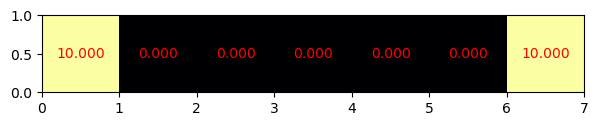

In [25]:
fig, ax = plt.subplots(figsize=(7,1))

def update(frame):
    cmap = plt.get_cmap('inferno')
    ax.clear()
    result = v_pi[frame]

    for i, value in enumerate(result):
        plt.text(i + 0.5, 0.5, f'{value:.3f}', color='red', ha='center', va='center')

    ax.imshow(np.array(result).reshape(1, -1), cmap=cmap, aspect='auto', extent=[0, len(result), 0, 1])

ani = FuncAnimation(fig, update, frames=len(v_pi), interval=500, repeat=False)

HTML(ani.to_jshtml())

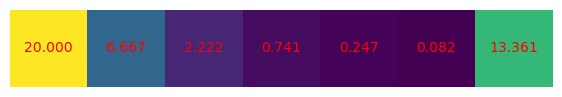

In [26]:
utils.plot_heatmap(v_pi[i])

From the slides: What if our policy is to ALWAYS go right?

## Policy Iteration

Q-Value of a policy:

$ Q^\pi(s,a) = R(s,a) + \gamma \sum_{s' \in S} P(s' \lvert s,a) V^\pi(s') $


In [27]:
def q(state, action, agent):
    if action in state.actions:
        p = environment.probability_matrix_df[(state.number,action.name)].to_list()

        return environment.rewards_df.loc[state.number, action.name] + environment.DISCOUNT_FACTOR * sum([  p[next_state.number] * agent.policy_evaluation[next_state.number] for next_state in environment.states])

In [28]:
q(environment.states[0], environment.states[0].actions[0], agent)

20.0

In [29]:
q(environment.states[6], environment.states[6].actions[1], agent)

16.680384087791495

When the policy is "always left", the second q-value is smaller because after going right we will try going left. 

(The usual policy is followed after the first movement)

Policy Iteration step

In [30]:
qs = {}
for state in environment.states:
    for action in state.actions:
        qs[(state.number, action.name)] = q(state, action, agent)

In [31]:
maxs = {}
for state in environment.states:
    maxs[state] = state.actions[0]
    for action in state.actions:
        if qs[(state.number, action.name)] > qs[(state.number, maxs[state].name)]:
            maxs[state] = action

In [32]:
new_policy = {}
for state in environment.states:
    for action in state.actions:
        if action == maxs[state]:
            new_policy[(state.number, action.name)] = 1
        else:
            new_policy[(state.number, action.name)] = 0

In [33]:
new_policy

{(0, 'left'): 1,
 (0, 'right'): 0,
 (1, 'left'): 1,
 (1, 'right'): 0,
 (2, 'left'): 1,
 (2, 'right'): 0,
 (3, 'left'): 1,
 (3, 'right'): 0,
 (4, 'left'): 1,
 (4, 'right'): 0,
 (5, 'left'): 0,
 (5, 'right'): 1,
 (6, 'left'): 0,
 (6, 'right'): 1}

After the first iteration, the policy changed slightly.

## Policy iteration loop

In [34]:
def q(state, action, agent):
    if action in state.actions:
        p = environment.probability_matrix_df[(state.number,action.name)].to_list()

        return environment.rewards_df.loc[state.number, action.name] + environment.DISCOUNT_FACTOR * sum([  p[next_state.number] * agent.policy_evaluation[next_state.number] for next_state in environment.states])

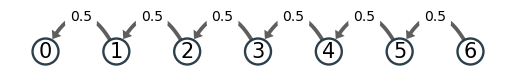

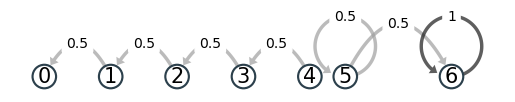

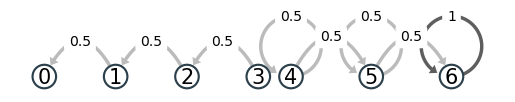

In [35]:
policies = [ None, agent.policy ]
old_policy = agent.policy
new_policy = {}
while policies[-2] != new_policy:
    utils.visualize_policy(environment, agent)

    qs = {}
    for state in environment.states:
        for action in state.actions:
            qs[(state.number, action.name)] = q(state, action, agent)

    maxs = {}
    for state in environment.states:
        maxs[state] = state.actions[0]
        for action in state.actions:
            if qs[(state.number, action.name)] > qs[(state.number, maxs[state].name)]:
                maxs[state] = action    

    new_policy = {}
    for state in environment.states:
        for action in state.actions:
            if action == maxs[state]:
                new_policy[(state.number, action.name)] = 1
            else:
                new_policy[(state.number, action.name)] = 0

    
    policies.append(new_policy)
    agent.change_policy(new_policy)

In [36]:
agent.easy_policy

{0: 'left',
 1: 'left',
 2: 'left',
 3: 'left',
 4: 'right',
 5: 'right',
 6: 'right'}

In [42]:
agent.sample_episode(10)

[4, 5, 5, 5, 6, 6, 6, 6, 6, 6]

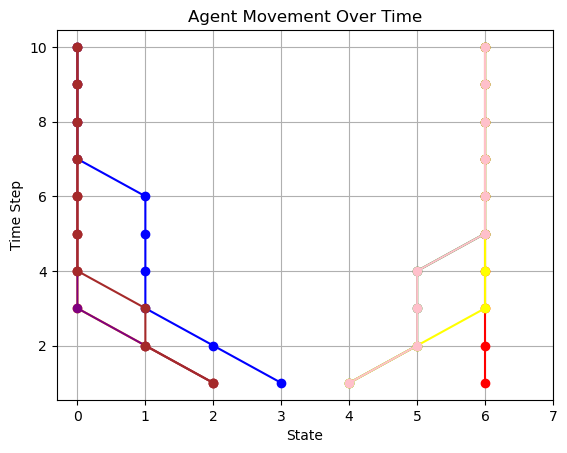

In [38]:
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'brown', 'pink']

for i in range(len(colors)):
    episode = agent.sample_episode(10)  
    time_steps = range(1, len(episode) + 1)
    plt.plot(episode, time_steps, marker='o', linestyle='-', color=colors[i])

plt.xlabel('State')
plt.ylabel('Time Step')
plt.xticks(np.arange(0, 8, step=1))
plt.title('Agent Movement Over Time')
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()